# Conformance Checking
*by: Sebastiaan J. van Zelst*

In this tutorial, we'll be focusing on *conformance checking*.
The conceptual idea of conformance checking is rather easy, i.e., computing to what degree a given process model conforms to the exeuction of a process, as recorded by the event data.
We are going to use the same process model as we have seen before, i.e., based on our [running example event log](data/running_example.csv):

![Running example BPMN-based process model describing the behavior of the simple process that we use in this tutorial](img/bpmn_running_example.png)

However, to check conformance w.r.t. the model, we're going to use a slightly [different event log](data/running_example_broken.csv).
In this tutorial, we'll consider two types of techniques, i.e., *token-based-replay*, and, *alignments*.


## Token-Based-Replay

In order to understand token-based-replay, we first need to cover a bit of Petri net theory.
Let's use the Petri net based on the clean [running example event log](data/running_example.csv), as an example.

In [1]:
%load_ext autoreload
%autoreload 2

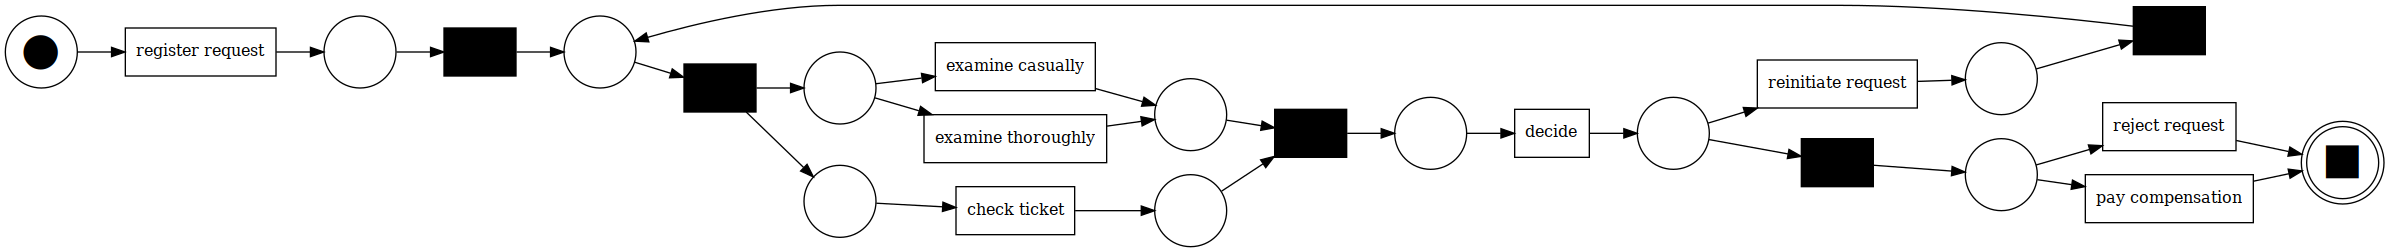

In [2]:
import pandas as pd
import pm4py
df = pm4py.format_dataframe(pd.read_csv('data/running_example.csv', sep=';'), case_id='case_id',activity_key='activity',
                             timestamp_key='timestamp')
pn, im, fm = pm4py.discover_petri_net_inductive(df)
pm4py.view_petri_net(pn, im, fm)

### Places and Transitions
Observe that the Petri net consists of two different type of nodes, i.e., cirlces and rectangles.
We refer to the circles as *places* and we refer to the rectangles as *transitions*.
Furthermore, notice that, a place can only be connected (by means of an arc) to a transition.
Similarly, a transition can only be connected (by means of an arc) to a place.
Hence, *places never connect directly to places* and *transitions never connect directly to transitions*.

### Tokens, Enabledness and Transition Firing
There is one place in the model containing a black 'dot'.
This dot is referred to as a *token*.
For convienence, let's call the place containing the token 'source'.
A transition can consume and produce tokens, referred to as *firing a transition*.
A transition is allowed to fire, if all of its 'incoming places' contain at least one token.
Any transition for which this property holds is referred to as an *enabled transition*.
In the example net, only the 'source' place contains a token.
Consequently, the only transition that has a token in all of its 'incoming places' is the transition *register request*, i.e., it is enabled.
If we diced to fire the an enabled transition, it consumes one token from each of its 'incoming places' and it produces a token in each of its 'outgoing places'.
For example, if we *fire* the *register request* transition, it consumes the token in the source place and it produces a fresh token in its outgoing place (i.e., the place connected to it by means of an outgoing arc).

*It is extremely important to note that there is no relationship between token production and consumption, i.e., tokens that are consumed cease to exist, tokens that are produced are always "fresh tokens"*.


### Token-Based-Replay - The Basics
When we use token-based-based-replay, we are effecitvely mimicking behavior observed in the event log in the context of a given process model.

Let's assume that in the event log, we observe the trace: 


$\langle \text{register request, examine casually, check ticket, decide, reject request} \rangle$

The token-based replay algorithm will simply mimick the trace in the model and keep track of the number of tokens we need to produce, respectively consume to *replay* the trace in the model.
For example, the first activity in the trace, i.e., *register request*, can be directly mimicked by consuming the token in the source place.
To subsequently fire the *examine causally* activity, we need the token produced by firing the *register request* transition.
The token needs to be consumed by the *black* transition (this is referred to as an invisible transition) that connects to the output place of the *register request* transition.
Said transition will produce two fresh tokens (observe that it has two outgoing places), one of which can subsequently be consumed by the *examine casually* transition.
Essentially, the token-based-replay algorithm keeps repeating this rationale, until it has mimicked the complete trace.

In the previous example, the trace can be completely mimicked (or *replayed*) by the model.
However, consider the trace:

$\langle \text{register request, examine casually, check ticket, reject request} \rangle$

When analyzing the trace, we observe that a decision is missing.
The token-based-replay algorithm can detect this, i.e., it can detect that due to the lack of the *decide* transition in the trace, when mimicking it, tokens would remain in the input places of the *decide* transition, and, similarly, tokens would be missing in the input place of the *reject request* transition.

For a given event log, the token-based-replay algorithm simply mimicks every trace in the event log, and, keeps track of the number of detected problems (missing and remaining tokens when mimicking the bahvior).
It subsequently compares the dected number of problems with the total amount of 'correct behavior' and produces a 'conformity score' (often referred to as a 'fitness' score) between $0$ and $1$.
If the score is $1$, no problems were detected.
If the score is $0$, no normal behavior was detected.

### Token-Based-Replay in pm4py

In [3]:
pm4py.fitness_token_based_replay(df, pn, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 1.0,
 'percentage_of_fitting_traces': 100.0}

In the previous example, we observe that all traces in the event log perfectly comply with the model.
This is the case because the algorithm we used always guarantees it, i.e., it will always describe all behavior given to it in the event log.

Let's consider computing fitness when using an event log that has some problems, i.e., w.r.t. the model that we learned on the clean event log.

In [4]:
df_problems = pm4py.format_dataframe(pd.read_csv('data/running_example_broken.csv', sep=';'), case_id='case:concept:name',activity_key='concept:name',
                             timestamp_key='time:timestamp')
pm4py.fitness_token_based_replay(df_problems, pn, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 16.666666666666668,
 'average_trace_fitness': 0.8235693400167085,
 'log_fitness': 0.8360655737704918,
 'percentage_of_fitting_traces': 16.666666666666668}

In this case, only $16\frac{2}{3}$ percent of the cases fits w.r.t. the model
Yet, the total fitness score is still $0.8$.
We can roughly interpret this as $80\%$ of the behavior in the event log is fitting the model.

### Using Other Process Model Formalisms

In ``pm4py``, the token-based-replay algorithm is only defined for Petri nets.
Hence, if we have other model types, e.g., a process tree or a BPMN model, we need to convert these to Petri nets.

In [5]:
tree = pm4py.discover_process_tree_inductive(df)
pn, im, fm = pm4py.convert_to_petri_net(tree)
pm4py.fitness_token_based_replay(df_problems, pn, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 16.666666666666668,
 'average_trace_fitness': 0.8235693400167085,
 'log_fitness': 0.8360655737704918,
 'percentage_of_fitting_traces': 16.666666666666668}

In [6]:
bpmn = pm4py.discover_process_tree_inductive(df)
pn, im, fm = pm4py.convert_to_petri_net(bpmn)
pm4py.fitness_token_based_replay(df_problems, pn, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 16.666666666666668,
 'average_trace_fitness': 0.8235693400167085,
 'log_fitness': 0.8360655737704918,
 'percentage_of_fitting_traces': 16.666666666666668}

In general, a process tree, i.e. no matter the source (whether it is designed by hand or discovered by a discovery algorithm), can always be translated into a Petri net, without any problems.
For BPMN models this is not the case.
In the example, we use the inductive miner, which always yields a process tree.
As such, the BPMN model we discovered is actually a process tree transformed into a BPMN model.
As a consequence, the subsequent transformation into a Petri net will not yield any problems.
However, in general, various quality issues can emerge when converting an arbitrary BPMN model into a Petri net, i.e., from a conformance checking perspective.

## Diagnostics

Thusfar, we have shown how to compute a number, quantifying how well the given event log and model conform to one another.
However, token-based-replay does not provide detailed diangostics on the problems detected (albeit we did implement rudimentary diagnostics based on token-based-replay).
To compute *conformance diagnostics* we advocate the use of *alignments*.
For convienence, let's again consider our process model:

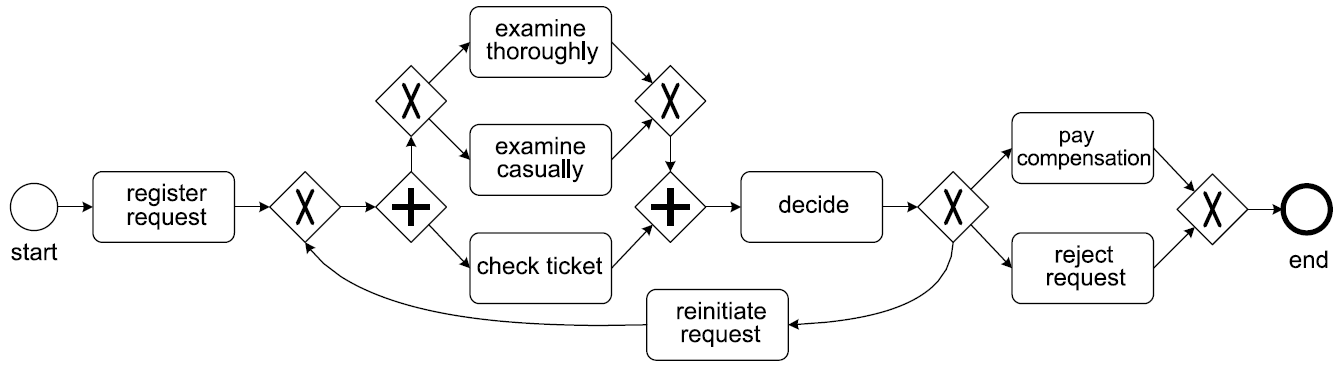

### Alignments


Simply put, an *alignmnet* maps the observed trace onto the *closest* firing sequence described by the model:
Let's revisit our earlier example, i.e., 

$\langle \text{register request, examine casually, check ticket, decide, reject request} \rangle$.

An alignment of the this trace looks as follows: 

$\langle \text{(register request,register request), (examine casually, examine casually), (check ticket, check ticket), (decide, decide), (reject request, reject request)} \rangle$.


The alignment is a sequence of pairs, e.g., $(register request,register request)$, $(examine casually, examine casually)$.
In each pair, the first element corresponds to observed behavior in the log whereas the second argument corresponds to an action in the model.
Hence, the closest 'behavior' that the observed trace can be moapped to is  $\langle \text{register request, examine casually, check ticket, decide, reject request} \rangle$, i.e., exactly the same sequence of action as the observed trace.
This makes sense as the model actually describes the observed trace.

### Non-Fitting Behavior

In certain cases, observed behavior cannot be mimicked by the model, or, behavior may be missing.
In both cases, we use the $\gg$ symbol to represent this.

For example, consider the trace: 

$\langle \text{register request, register request, examine casually, check ticket, reject request} \rangle$

It is quite easy to see that, given the reference model presented earlier, the *register request* transition is duplicated, and, the *decide* activity is missing.
An alignment of the trace w.r.t. the model shown before quantifies this exactly:

$\langle \text{(register request, register request), (register request, }\gg\text{), (examine casually, examine casually), (check ticket, check ticket), (}\gg\text{, decide), (reject request, reject request)} \rangle$

The elements of the alignment (which we refer to as moves) reflect our observation before.

1. The firs *register request* activity is also described by the model
2. The second *register request* activity is not described by the model (i.e., the first argument refers to the trace, the 2nd argument $\gg$ represents to the model).
3. The *examine casually* activity is described by the log and the model
4. The *check ticket* activity is described by the log and the model
5. The *decide* activity was not observed in the data, yet, the model describes that it is supposed to be observed
6. The *reject request* activity is described by the log and the model

Observe that, according to the alignment, the given trace should be mapped on the following model behavior:

$\langle \text{register request, examine casually, check ticket, decide, reject request} \rangle$

### Alignments in pm4py

Like token-based-replay, computing alignments in ``pm4py`` is rather straightforward:

In [7]:
pn, im, fm = pm4py.discover_petri_net_inductive(df)
pm4py.conformance_diagnostics_alignments(df_problems, pn, im, fm)

aligning log, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

[{'alignment': [('>>', 'register request'),
   ('>>', None),
   ('>>', None),
   ('examine thoroughly', 'examine thoroughly'),
   ('check ticket', 'check ticket'),
   ('>>', None),
   ('decide', 'decide'),
   ('>>', None),
   ('reject request', 'reject request')],
  'cost': 10004,
  'visited_states': 9,
  'queued_states': 26,
  'traversed_arcs': 26,
  'lp_solved': 1,
  'fitness': 0.8888888888888888,
  'bwc': 90004},
 {'alignment': [('register request', 'register request'),
   ('>>', None),
   ('>>', None),
   ('check ticket', 'check ticket'),
   ('examine casually', 'examine casually'),
   ('>>', None),
   ('>>', 'decide'),
   ('>>', None),
   ('pay compensation', 'pay compensation')],
  'cost': 10004,
  'visited_states': 9,
  'queued_states': 27,
  'traversed_arcs': 27,
  'lp_solved': 13,
  'fitness': 0.8888888888888888,
  'bwc': 90004},
 {'alignment': [('register request', 'register request'),
   ('>>', None),
   ('>>', None),
   ('>>', 'examine thoroughly'),
   ('check ticket', 'che

Like token-based-replay, alignments can also be used to quantify 'fitness':

In [8]:
pm4py.fitness_alignments(df_problems, pn, im, fm)

aligning log, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

{'percFitTraces': 16.666666666666668,
 'averageFitness': 0.8446623093681916,
 'percentage_of_fitting_traces': 16.666666666666668,
 'average_trace_fitness': 0.8446623093681916,
 'log_fitness': 0.8437089859130282}